# Processing Daily Climate Anomalies using 1982-2011 Climatology

## 2. Daily Global Temperature Anomalies

General Workflow is to Load:
 1. Netcdf files containing observed SST from 1981-Present
 2. Netcdf containing 30-year Climatology Means for each day of the year
 
Next step is to pair each observed daily mean with the appropriate 30-year climatology and calculate the difference

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os

#ensure we're in correct directory/volume
#os.chdir("/Users/akemberling/Documents/oisst_mainstays_local/annual_oisst")
os.chdir("/home/jovyan/NSF OKN Demo Data/oisst") #when working in container

#Suppress divide by NA error
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Open Daily Climatologies 

In [2]:
#daily_clims = xr.open_dataset('daily_climatologies/daily_clims_82to2011.nc')
daily_clims = xr.open_mfdataset('daily_climatologies/daily_clims_82to2011.nc',
                               combine = "by_coords")
daily_clims

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, modified_ordinal_day: 366)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Data variables:
    sst                   (modified_ordinal_day, lat, lon) float32 dask.array<chunksize=(366, 720, 1440), meta=np.ndarray>

### Plot Single Day Test

In [3]:
def plot_yearday_sst(day_year = 1):
    
    daily_sst = daily_clims['sst'].sel(modified_ordinal_day = day_year)
    
    fig = plt.figure(figsize=[12,5])

    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
    fig.suptitle('30-Year SST Climatology for the ' + str(day_year) + 'th day of the year.', fontsize=16)

    daily_sst.plot.contourf(ax=ax,
                       levels=np.arange(0, 30, 1.5),
                       extend='max',
                       transform=ccrs.PlateCarree(),
                       cbar_kwargs={'label': daily_sst.units})
    ax.coastlines()

    plt.show()

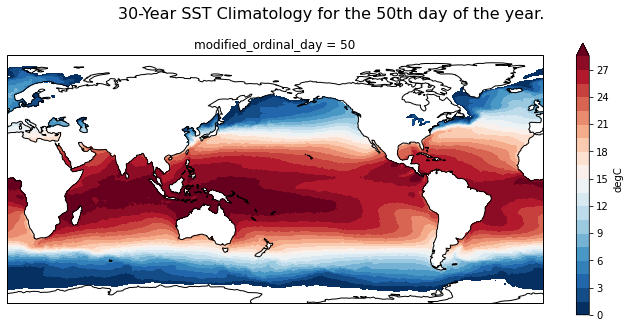

In [4]:
plot_yearday_sst(day_year = 50)

## Load Netcdf Files for Daily SST Data
Lazy-load the annual netcdf files for the oisst sst data. Once again we will be taking advantage of {xarray} here to load them as a single object and not repeat steps for each year.

In [5]:
#Load/append all the annual netcdf files
start_year = 1982
end_year = 2021
my_years = np.arange(start_year, end_year, 1)
nc_files = []
for i in my_years:
    nc_files.append("annual_observations/sst.day.mean." + str(i) + ".v2.nc")

print(nc_files[0:6])

['annual_observations/sst.day.mean.1982.v2.nc', 'annual_observations/sst.day.mean.1983.v2.nc', 'annual_observations/sst.day.mean.1984.v2.nc', 'annual_observations/sst.day.mean.1985.v2.nc', 'annual_observations/sst.day.mean.1986.v2.nc', 'annual_observations/sst.day.mean.1987.v2.nc']


In [6]:
sst_obs = xr.open_mfdataset(nc_files, parallel=False, combine='by_coords')
sst_obs

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 14123)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2020-08-31
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(365, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

## Re-creating Modified Ordinal Day Index

To account for leap-years the daily climatology was calculated using a modified ordinal day, with which March 1st is always the 60th day of the of the index, with February 29th occupying the 59th value in the event that it occurs. In order to match the daily observations to these values we need an index of what day of the year it is (that isn't sensitive to leap-years) to match the observed sst values with the 30-year climatologies.

In [7]:
not_leap_year = ~sst_obs.indexes['time'].is_leap_year

march_or_later = sst_obs.time.dt.month >= 3

ordinal_day = sst_obs.time.dt.dayofyear

modified_ordinal_day = ordinal_day + (not_leap_year & march_or_later)

modified_ordinal_day = modified_ordinal_day.rename('modified_ordinal_day')

Now add that dimension to the big observed sst array

In [8]:
modified_ordinal_day

<xarray.DataArray 'modified_ordinal_day' (time: 14123)>
array([  1,   2,   3, ..., 242, 243, 244])
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2020-08-31

In [13]:
#Add modified ordinal day as a variable
sst_obs = sst_obs.assign(modified_ordinal_day = modified_ordinal_day)

#Maybe need to add modified ordinal day as coordinate as well
sst_obs = sst_obs.assign_coords(MOD = modified_ordinal_day)
sst_obs

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 14123)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * time                  (time) datetime64[ns] 1982-01-01 ... 2020-08-31
    MOD                   (time) int64 1 2 3 4 5 6 7 ... 239 240 241 242 243 244
Data variables:
    sst                   (time, lat, lon) float32 dask.array<chunksize=(365, 720, 1440), meta=np.ndarray>
    modified_ordinal_day  (time) int64 1 2 3 4 5 6 7 ... 239 240 241 242 243 244
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

In [14]:
#compare to daily climatologies structure
daily_clims

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, modified_ordinal_day: 366)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Data variables:
    sst                   (modified_ordinal_day, lat, lon) float32 dask.array<chunksize=(366, 720, 1440), meta=np.ndarray>

In [15]:
#Indexing by coordinates
sst_obs[dict(lat=0, lon=0, time=0)]['sst']

<xarray.DataArray 'sst' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 -89.875
    lon      float32 0.125
    time     datetime64[ns] 1982-01-01
    MOD      int64 1
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.48]

In [16]:
#Do they align with the time coord?
sst_obs.sel(time='2000-03-01')

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
    time                  datetime64[ns] 2000-03-01
    MOD                   int64 61
Data variables:
    sst                   (lat, lon) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    modified_ordinal_day  int64 61
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

### Matching them up for arithmetic
So now the observed dataset contains the modified ordinal day of the year which we can use to match with the corresponding daily climatology

In [17]:
test_day_obs = sst_obs.sel(time='2000-03-01')
test_day_obs

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
    time                  datetime64[ns] 2000-03-01
    MOD                   int64 61
Data variables:
    sst                   (lat, lon) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    modified_ordinal_day  int64 61
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

In [18]:
test_day_clim = daily_clims.sel(modified_ordinal_day = test_day_obs["MOD"])
test_day_clim

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
    modified_ordinal_day  int64 61
    time                  datetime64[ns] 2000-03-01
    MOD                   int64 61
Data variables:
    sst                   (lat, lon) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>

In [19]:
test_day_anom = test_day_obs - test_day_clim
test_day_anom = test_day_anom['sst'].rename('sst_anom')

### Test Day Anomaly - Plot

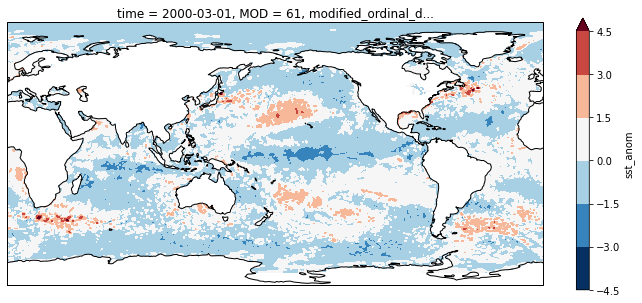

In [20]:
fig = plt.figure(figsize=[12,5])

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))

test_day_anom.plot.contourf(
    ax=ax,
    levels=np.arange(-4.5, 6, 1.5),
    extend='max',
    transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

## GroupBy "time": split-apply-combine
So from the full daily set, we want to group by the time to split out each day. Then use the modified ordinal day to subtract the matching climatology. I don't think we'll need to worry about the leap-years but we'll see...

In [21]:
sst_obs.groupby('time')

DatasetGroupBy, grouped over 'time' 
14123 groups with labels 1982-01-01, ..., 2020-08-31.

Define the function that will take a daily slice of the observed sst, and subtract it by its matching climatology:

In [22]:
def calc_anom(daily_sst):
    return daily_sst - daily_clims.sel(modified_ordinal_day = daily_sst["MOD"])

### Moment of Truth
Can we apply it top every day?

In [25]:
daily_anoms = sst_obs.groupby('time').map(calc_anom)
daily_anoms

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 14123)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * time                  (time) datetime64[ns] 1982-01-01 ... 2020-08-31
    MOD                   (time) int64 1 2 3 4 5 6 7 ... 239 240 241 242 243 244
    modified_ordinal_day  (time) int64 1 2 3 4 5 6 7 ... 239 240 241 242 243 244
Data variables:
    sst                   (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

### Plot Test...

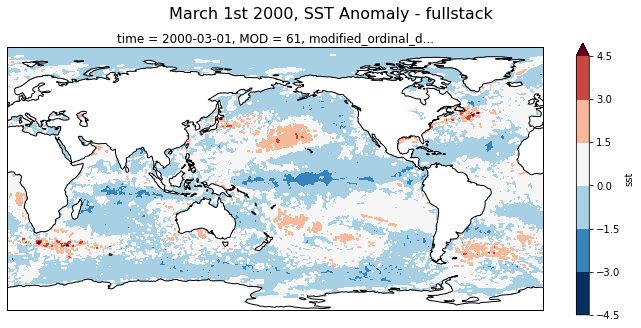

In [26]:
fig = plt.figure(figsize=[12,5])

ax = fig.add_subplot(111, projection = ccrs.PlateCarree(central_longitude = 180))
fig.suptitle('March 1st 2000, SST Anomaly - fullstack', fontsize = 16)

daily_anoms.sel(time = '2000-03-01')['sst'].plot.contourf(
    ax=ax,
    levels=np.arange(-4.5, 6, 1.5),
    extend='max',
    transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

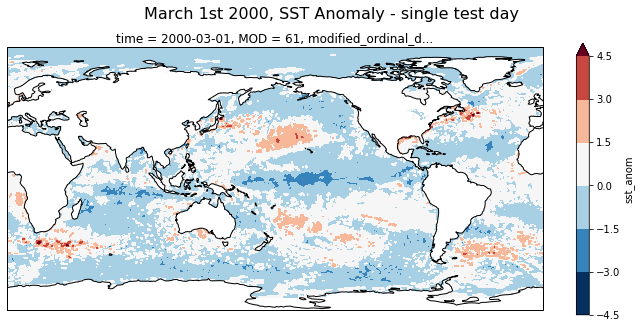

In [24]:
fig = plt.figure(figsize=[12,5])

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
fig.suptitle('March 1st 2000, SST Anomaly - single test day', fontsize=16)

test_day_anom.plot.contourf(
    ax = ax,
    levels = np.arange(-4.5, 6, 1.5),
    extend = 'max',
    transform = ccrs.PlateCarree())

ax.coastlines()

plt.show()

## Update Attributes:

Just like with the climatology it is good to add metadata attributes.

In [29]:
sst_obs.attrs

{'Conventions': 'CF-1.5',
 'title': 'NOAA High-resolution Blended Analysis: Daily Values using AVHRR only',
 'institution': 'NOAA/NCDC',
 'source': 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/',
 'comment': 'Reynolds, et al., 2007: Daily High-Resolution-Blended Analyses for Sea Surface Temperature. J. Climate, 20, 5473-5496.  Climatology is based on 1971-2000 OI.v2 SST, Satellite data: Navy NOAA17 NOAA18 AVHRR, Ice data: NCEP ice.',
 'history': 'Thu Aug 24 13:35:47 2017: ncatted -O -a References,global,d,, sst.day.mean.1982.v2.nc\nVersion 1.0',
 'references': 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html',
 'dataset_title': 'NOAA Daily Optimum Interpolation Sea Surface Temperature'}

In [31]:
#Change the Attributes for the dataset
daily_anoms.attrs['title']         = 'Sea surface temperature anomalies from NOAA OISSTv2 SST Data using 82-2011 Climatology'
daily_anoms.attrs['institution']   = 'Gulf of Maine Research Institute'
daily_anoms.attrs['source']        = 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/'
daily_anoms.attrs['comment']       = 'Climatology used represents mean SST for the years 1982-2011'
daily_anoms.attrs['history']       = 'Anomalies calculated 3/2/2020'
daily_anoms.attrs['references']    = 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html'
daily_anoms.attrs['dataset_title'] = 'Sea Surface Temperature Anomalies - OISSTv2'
daily_anoms.attrs

{'title': 'Sea surface temperature anomalies from NOAA OISSTv2 SST Data using 82-2011 Climatology',
 'institution': 'Gulf of Maine Research Institute',
 'source': 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/',
 'comment': 'Climatology used represents mean SST for the years 1982-2011',
 'history': 'Anomalies calculated 3/2/2020',
 'references': 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html',
 'dataset_title': 'Sea Surface Temperature Anomalies - OISSTv2'}

In [26]:
#Export as annual netcdf files
# for year, group in daily_anoms.groupby('time.year'):
#     group.to_netcdf(f'/Users/akemberling/Documents/oisst_mainstays/annual_anomalies/daily_anoms_{year}.nc')

# Save to box    
for year, group in daily_anoms.groupby('time.year'):
    group.to_netcdf(f'annual_anomalies/daily_anoms_{year}.nc')
